<p align="center"><h1 align="center">QMSS5074GR <br> Projects in Advanced Machine Learning <br>Spring 2024 <br> FINAL PROJECT <br>Assignment 3 Part 2 [GROUP Assignment]</h1>

---
<br>

#### **Your Unis** : sc4040, ajh2259, fsa2139
#### **Your Full names** : Shayan Chowdhury, Andrew Hamilton, Faaz Saad Arshad
#### **Your AI Model Share Usernames**: sc4040, ajh2259, fsa2139
#### **Link to your Public Github repository** : https://github.com/fsarshad/NLPAdvMLHW3
#### **Team member Contribution Percentages** : 33.33%, 33.33%, 33.33%

## Stanford Sentiment Treebank - Movie Review Classification Competition


## **Instructions: [Total 85 Points for this part]**
1.   Get data in and set up X_train / X_test / y_train
2.   Preprocess data using keras Tokenizer/ Write and Save Preprocessor function
3. Fit model on preprocessed data and save preprocessor function and model
4. Generate predictions from X_test data and submit model to competition
5. Repeat submission process to improve place on leaderboard



## 1. Get data in and set up X_train, X_test, y_train objects

In [ ]:
#install aimodelshare library
! pip install -q aimodelshare

In [1]:
# Get competition data
from aimodelshare import download_data
download_data('public.ecr.aws/y2e2a1d6/sst2_competition_data-repository:latest')


Data downloaded successfully.


In [ ]:
!mv -r sst2_competition_data data/sst2_competition_data

# Setup 
Rerun after every time runtime crashes

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Conv1D, Dense, Flatten, Dropout, Embedding, GlobalMaxPooling1D, BatchNormalization, SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

import warnings
warnings.simplefilter(action='ignore', category=Warning)

In [15]:
# HELPER FUNCTIONS

def plot_history(history, title='Model Performance'):
    # Plot the training history (loss + accuracy)
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    # fig, ax = plt.subplots(1, 2, figsize=(20, 5)) 

    fig.suptitle(title, fontsize=16)

    # Plot training & validation loss values in the first subplot
    axs[0].plot(history.history['loss'])
    axs[0].plot(history.history['val_loss'])
    axs[0].set_title('Model loss')
    axs[0].set_ylabel('Loss')
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['Train', 'Val'])

    # Plot training & validation accuracy values in the second subplot
    if 'accuracy' in history.history:
        axs[1].plot(history.history['accuracy'])
        axs[1].plot(history.history['val_accuracy'])
    elif 'acc' in history.history:
        axs[1].plot(history.history['acc'])
        axs[1].plot(history.history['val_acc'])
    axs[1].set_title('Model accuracy')
    axs[1].set_ylabel('Accuracy')
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['Train', 'Val'])

    # Adjust the spacing between subplots
    plt.tight_layout()

    # Show the combined plot
    plt.show()

from aimodelshare.aimsonnx import model_to_onnx

# Save tf.keras model (or any tensorflow model) to local ONNX file
def save_model_onxx(model, model_filename, framework='keras', transfer_learning=False, deep_learning=False):
    onnx_model = model_to_onnx(
        model,
        framework=framework,
        transfer_learning=transfer_learning,
        deep_learning=deep_learning
    )

    with open(model_filename, "wb") as f:
        f.write(onnx_model.SerializeToString())
        print(f"Model saved to {model_filename}")

# Upload predictions to AI Model Share
def upload_preds_to_aimodelshare(model, model_filename, X_test, columns, competition, preprocessor_filename='preprocessor.zip'):
    # Generate predictions and extract the index of the highest probability
    prediction_column_index = model.predict(X_test).argmax(axis=1)
    # Extract the text labels for the highest probability index
    prediction_labels = [columns[i] for i in prediction_column_index]
    # Submit predictions to competition Leaderboard
    competition.submit_model(
        model=model_filename,
        preprocessor=preprocessor_filename,
        prediction_submission=prediction_labels
    )

# Get leaderboard to explore current best model architectures
def show_leaderboard(competition):
    # Get raw data in pandas data frame
    data = competition.get_leaderboard()
    # Stylize leaderboard data
    return competition.stylize_leaderboard(data)

## IMPORTANT NOTE
This X_test has no relation to test_sample.csv
This X_test (downloaded from above link) is for prediction and submission to aimodelshare only. You can create a validation split from the X_train here or during instatiating the model.

The test_sample.csv is meant for only inference from your best 3 saved models, and is only meant to be used in the final front-end notebook (See last section, Note that it has a very high weightage in this assignment). Predicting the labels in correct format on this test_sample may also require you to change your preprocessing and transform code. Ensure you code it correctly and that your final front-end notebook can predict on it appropriately.

None of the training code in this notebook will go into your python files in Github or your front-end notebook (See last cell instructions)

In [16]:
# Set up X_train, X_test, and y_train_labels objects
X_train = pd.read_csv("data/sst2_competition_data/X_train.csv", usecols=['text']).squeeze()
X_test = pd.read_csv("data/sst2_competition_data/X_test.csv", usecols=['text']).squeeze()
y_train_labels = pd.read_csv("data/sst2_competition_data/y_train_labels.csv",usecols=['label']).squeeze()

# Convert to series if your following preprocessor needs it

# One hot encode encode Y data here
y_train = pd.get_dummies(y_train_labels)

X_train.head()

0    The Rock is destined to be the 21st Century 's...
1    The gorgeously elaborate continuation of `` Th...
2    Singer/composer Bryan Adams contributes a slew...
3                 Yet the act is still charming here .
4    Whether or not you 're enlightened by any of D...
Name: text, dtype: object

## 2.   Preprocess data using keras tokenizer / Write and Save Preprocessor function


In [17]:
MAX_WORDS = 10000 # Maximum number of words to keep in tokenizer
MAX_LENGTH = 100 # Maximum length of text data

# [3 Pts]for this cell
# Build vocabulary from training text data
tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(X_train)

# This preprocessor function makes use of the tf.keras tokenizer
# preprocessor tokenizes words and makes sure all documents have the same length (perform padding with maxlen=40)
def preprocessor(data, max_length=MAX_LENGTH):
    # Use tokenizer to convert text data to sequences
    sequences = tokenizer.texts_to_sequences(data)
    # Pad sequences to ensure uniform length
    sequences = pad_sequences(sequences, maxlen=max_length)
    return sequences

print(preprocessor(X_train).shape)
print(preprocessor(X_test).shape)

(6920, 100)
(1821, 100)


In [18]:
# Set up AI Model Share
import aimodelshare as ai
from aimodelshare.aws import set_credentials

# Set up AWS credentials w/ aimodelshare.org username/password
apiurl = "https://rlxjxnoql9.execute-api.us-east-1.amazonaws.com/prod/m" # This is the unique rest api that powers this specific Playground
set_credentials(apiurl=apiurl)

# Instantiate AIModelShare competition
mycompetition = ai.Competition(apiurl)

# Save preprocessor function to local file
ai.export_preprocessor(preprocessor,"")

Modelshare.ai login credentials set successfully.
Your preprocessor is now saved to 'preprocessor.zip'


# 3. Fit model on preprocessed data and save preprocessor function and model


In [82]:
# A basic deep learning model (max 5 layers)  # [1 Pts]
model_basic = Sequential([
    Embedding(10000, 16, input_length=MAX_LENGTH),
    Flatten(),
    Dense(2, activation='softmax')
])
model_basic.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 100, 16)           160000    
                                                                 
 flatten_1 (Flatten)         (None, 1600)              0         
                                                                 
 dense_11 (Dense)            (None, 2)                 3202      
                                                                 
Total params: 163202 (637.51 KB)
Trainable params: 163202 (637.51 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [83]:
# Compile model
model_basic.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

# Do validation split here.

# Set up callbacks
checkpoint = ModelCheckpoint(
    'models/model.h5',
    monitor = 'val_loss',
    verbose = 1,
    save_best_only = True
)
reduce_lr = ReduceLROnPlateau(
    monitor = 'val_loss',
    factor = 0.2,
    verbose = 1,
    patience = 5,
    min_lr = 0.001
)

# Train model
history_model_basic = model_basic.fit(
    preprocessor(X_train),
    y_train,
    epochs = 10,
    batch_size = 32,
    validation_split=0.2,
    verbose = 1,
    callbacks = [reduce_lr, checkpoint]
)

Epoch 1/10
173/173 [==============================] - ETA: 0s - loss: 0.6665 - accuracy: 0.6145
Epoch 1: val_loss improved from inf to 0.97679, saving model to model.h5
173/173 [==============================] - 20s 105ms/step - loss: 0.6665 - accuracy: 0.6145 - val_loss: 0.9768 - val_accuracy: 0.1488 - lr: 0.0010
Epoch 2/10
172/173 [============================>.] - ETA: 0s - loss: 0.6201 - accuracy: 0.6346
Epoch 2: val_loss improved from 0.97679 to 0.82596, saving model to model.h5
173/173 [==============================] - 9s 50ms/step - loss: 0.6196 - accuracy: 0.6360 - val_loss: 0.8260 - val_accuracy: 0.2478 - lr: 0.0010
Epoch 3/10
173/173 [==============================] - ETA: 0s - loss: 0.5182 - accuracy: 0.7643
Epoch 3: val_loss improved from 0.82596 to 0.72027, saving model to model.h5
173/173 [==============================] - 8s 44ms/step - loss: 0.5182 - accuracy: 0.7643 - val_loss: 0.7203 - val_accuracy: 0.4942 - lr: 0.0010
Epoch 4/10
173/173 [============================

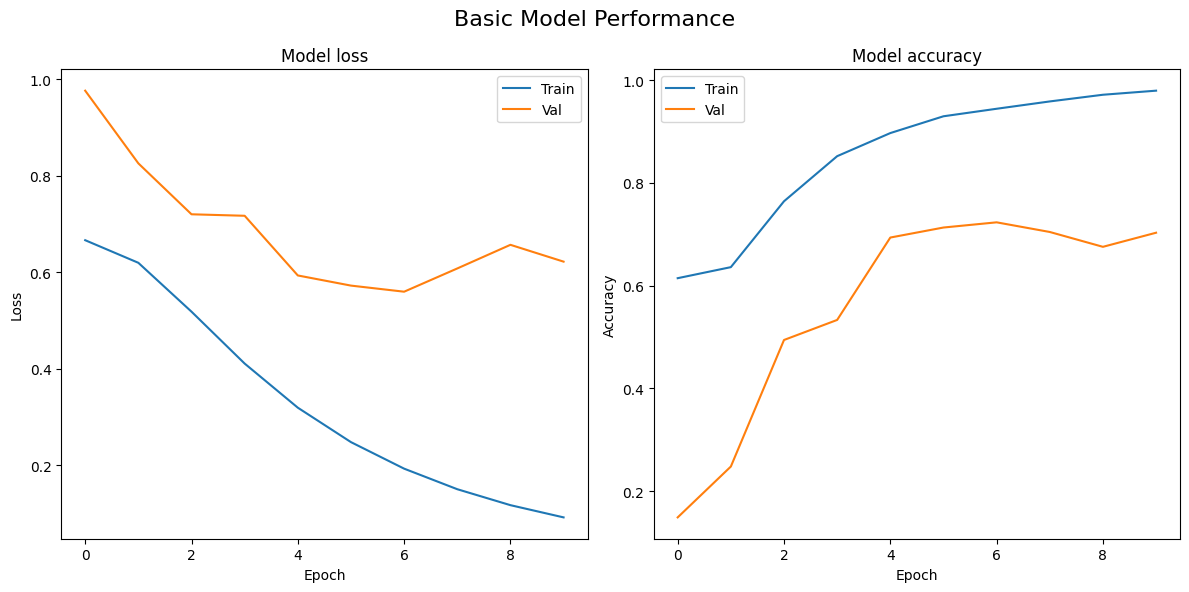

In [88]:
# Plot history [1 Pts]
plot_history(history_model_basic, title='Basic Model Performance')

In [ ]:
# Save basic model to ONNX file
save_model_onxx(
    model=model_basic, 
    model_filename="models/model.onnx",
    deep_learning=True
)

# Generate predictions and submit to competition
upload_preds_to_aimodelshare(
    model=model_basic,
    model_filename="models/model.onnx",
    X_test=preprocessor(X_test),
    columns=y_train.columns,
    competition=mycompetition,
    preprocessor_filename="preprocessor.zip"
)

In [15]:
# Finally, show the leaderboard
show_leaderboard(mycompetition)

## 5. Repeat submission process to improve place on leaderboard


In [28]:
# Preprocess text data
X_train_preproc = preprocessor(X_train)

print('Shape of preprocessed text data tensor:', X_train_preproc.shape)
print('Shape of label tensor:', y_train.shape)

Shape of preprocessed text data tensor: (6920, 100)
Shape of label tensor: (6920, 2)


In [29]:
# Train and submit model 2 using same preprocessor (note that you could save a new preprocessor, but we will use the same one for this example).
# Code an model with atleast 3 LSTM layers (with Embedding Layer) # [1 Pts]
model_lstm = Sequential([
    Embedding(10000, 32, input_length=MAX_LENGTH),
    LSTM(32, return_sequences=True),
    LSTM(32, return_sequences=True),
    LSTM(32),
    Dense(2, activation='sigmoid')
])

model_lstm.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 32)           320000    
                                                                 
 lstm (LSTM)                 (None, 100, 32)           8320      
                                                                 
 lstm_1 (LSTM)               (None, 100, 32)           8320      
                                                                 
 lstm_2 (LSTM)               (None, 32)                8320      
                                                                 
 dense (Dense)               (None, 2)                 66        
                                                                 
Total params: 345026 (1.32 MB)
Trainable params: 345026 (1.32 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [94]:
# Set up callbacks
# Checkpoint: save the model with the best validation loss
checkpoint = ModelCheckpoint('models/model_lstm.h5', monitor='val_loss', verbose=1, save_best_only=True)

# Learning rate scheduler: reduce the learning rate by 10% after every 5 epochs if the validation loss does not improve
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, mode='auto', min_lr=1e-6)

# Early stopping: stop training if the validation loss does not improve after 10 epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')

# Train LSTM model
history_model_lstm = model_lstm.fit(
    X_train_preproc, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    callbacks=[checkpoint, lr_scheduler, early_stopping]
)

Epoch 1/20
173/173 [==============================] - 32s 136ms/step - loss: 0.6357 - accuracy: 0.6407 - val_loss: 0.7152 - val_accuracy: 0.5853
Epoch 2/20
173/173 [==============================] - 11s 63ms/step - loss: 0.4417 - accuracy: 0.8027 - val_loss: 0.6245 - val_accuracy: 0.6676
Epoch 3/20
173/173 [==============================] - 10s 57ms/step - loss: 0.3260 - accuracy: 0.8611 - val_loss: 0.4605 - val_accuracy: 0.8280
Epoch 4/20
173/173 [==============================] - 16s 94ms/step - loss: 0.2575 - accuracy: 0.8954 - val_loss: 0.5215 - val_accuracy: 0.7558
Epoch 5/20
173/173 [==============================] - 11s 65ms/step - loss: 0.2036 - accuracy: 0.9171 - val_loss: 0.4579 - val_accuracy: 0.8208
Epoch 6/20
173/173 [==============================] - 8s 49ms/step - loss: 0.1705 - accuracy: 0.9344 - val_loss: 0.4988 - val_accuracy: 0.8027
Epoch 7/20
173/173 [==============================] - 8s 49ms/step - loss: 0.1402 - accuracy: 0.9438 - val_loss: 0.6155 - val_accuracy: 

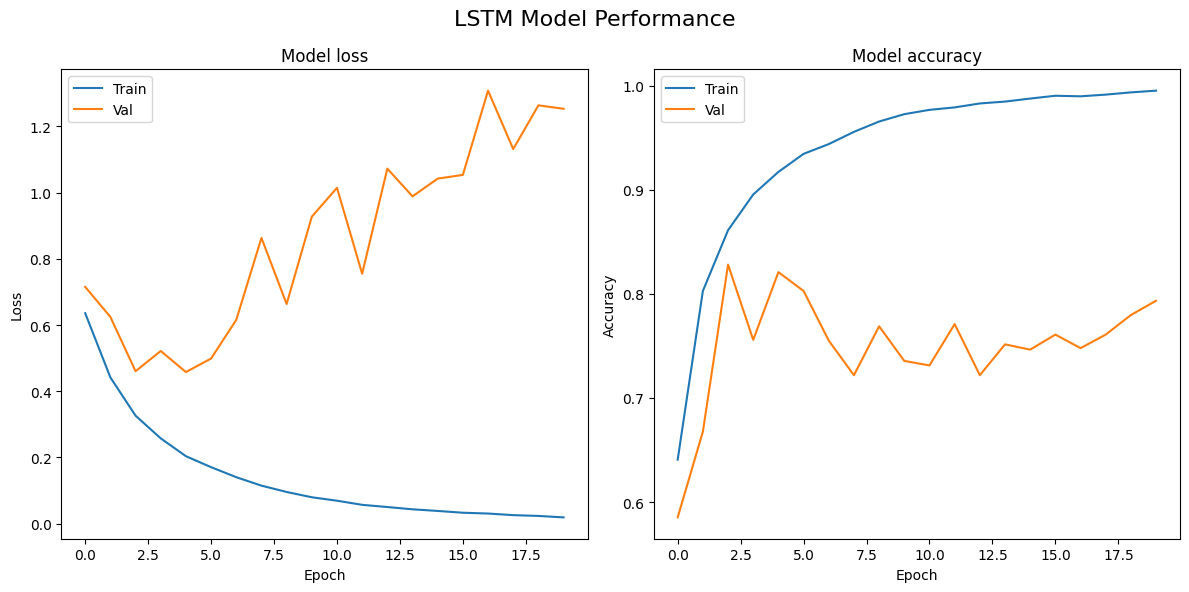

In [99]:
# Plot history [1 Pts]
plot_history(history_model_lstm, title='LSTM Model Performance')

**Does your model perform better or worse than your prior deep learning model? Why might that be the case? [1 Pts]**

Compared to the basic deep learning model, the LSTM model performed better in both training accuracy (0.99 vs 0.94) AND val_accuracy (0.74 vs 0.68). This is most likely because the LSTM is capturing long-term dependencies and sequential context in the review data that the basic deep learning model cannot. Being able to remember information from the beginning of the sequence and use it to make predictions at the end of the sequence, makes the LSTM model far more effective at predicting the most likely sentiment of the review. The basic deep learning model, on the other hand, treats each word in the review as independent and does not consider the order of the words—making it far less effective. 

However, we do note that the LSTM model is overfitting to the training data, as the training accuracy is significantly higher than the validation accuracy—and the validation loss is increasing while the training loss continues to decrease. To address this, we could try adding dropout layers or using regularization techniques.

In [ ]:
# Save LSTM model to ONNX file
save_model_onxx(
    model=model_lstm, 
    model_filename="models/model_lstm.onnx",
    deep_learning=True
)

# Generate predictions and submit to competition
upload_preds_to_aimodelshare(
    model=model_lstm,
    model_filename="models/model_lstm.onnx",
    X_test=preprocessor(X_test), 
    columns=y_train.columns,
    competition=mycompetition,
    preprocessor_filename="preprocessor.zip"
)

# Finally, show the leaderboard
show_leaderboard(mycompetition)

In [42]:
# Compare two or more models
data = mycompetition.compare_models([536, 542], verbose=1)
mycompetition.stylize_compare(data)

,Model_536_Layer,Model_536_Shape,Model_536_Params,Model_542_Layer,Model_542_Shape,Model_542_Params
0,Embedding,"[None, 40, 16]",160000.000000,Embedding,"[None, 100, 32]",320000
1,Flatten,"[None, 640]",0.000000,LSTM,"[None, 100, 32]",8320
2,Dense,"[None, 2]",1282.000000,LSTM,"[None, 100, 32]",8320
3,None,None,nan,LSTM,"[None, 32]",8320
4,None,None,nan,Dense,"[None, 1]",33


## Tune model within range of hyperparameters with Keras Tuner

*Consult [documentation](https://keras.io/guides/keras_tuner/getting_started/) to see full functionality.*

In [ ]:
! pip install keras_tuner

In [96]:
#Separate validation data here
from sklearn.model_selection import train_test_split
x_train_split, x_val, y_train_split, y_val = train_test_split(
     X_train, y_train, test_size=0.2, random_state=42
)

In [97]:
import keras_tuner as kt

# Define model structure & parameter search space with a function
# code LSTM--based model with provision for searching hyperparameter space, return model  # [3 Pts]
def build_model(hp):
    model = Sequential([
        Embedding(input_dim=MAX_WORDS, output_dim=hp.Int('embedding_dim', min_value=32, max_value=256, step=32), input_length=MAX_LENGTH),
        LSTM(units=hp.Int('lstm_units', min_value=32, max_value=256, step=32)),
        Dense(units=hp.Int('dense_units', min_value=32, max_value=256, step=32), activation='relu'),
        Dense(2, activation='sigmoid')
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
        ),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

#initialize the keras search tuner (which will search through parameters)   # [3 Pts]
# Define the following:
#Your function that returns the model
#objective to optimize
#max number of trials to run during search
#higher number reduces variance of results; guages model performance more accurately
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    project_name='models/model_lstm_tuning'
)

# Preprocess data
x_train_split = preprocessor(x_train_split)
x_val = preprocessor(x_val)

# Run the tuner feeding it the validation data
tuner.search(x_train_split, y_train_split, epochs=10, validation_data=(x_val, y_val))

Reloading Tuner from ./lstm_tuning/tuner0.json


In [102]:
# [3 Pts]

# Build model with best hyperparameters

# Get the top 2 hyperparameters.
best_hps = tuner.get_best_hyperparameters(num_trials=2)

# Build the model with the best hp.
tuned_model = tuner.hypermodel.build(best_hps[0])

# Fit with the entire dataset.
X_train_preproc = preprocessor(X_train)
history_tuned_model = tuned_model.fit(X_train_preproc, y_train, epochs=10, validation_split=0.2)

Epoch 1/10
173/173 [==============================] - 20s 96ms/step - loss: 0.6739 - accuracy: 0.6118 - val_loss: 0.9141 - val_accuracy: 0.1488
Epoch 2/10
173/173 [==============================] - 10s 56ms/step - loss: 0.6384 - accuracy: 0.6250 - val_loss: 0.8543 - val_accuracy: 0.2377
Epoch 3/10
173/173 [==============================] - 9s 53ms/step - loss: 0.4825 - accuracy: 0.7657 - val_loss: 0.6209 - val_accuracy: 0.7038
Epoch 4/10
173/173 [==============================] - 11s 62ms/step - loss: 0.2900 - accuracy: 0.8909 - val_loss: 0.5005 - val_accuracy: 0.7854
Epoch 5/10
173/173 [==============================] - 8s 46ms/step - loss: 0.2092 - accuracy: 0.9221 - val_loss: 0.6893 - val_accuracy: 0.7247
Epoch 6/10
173/173 [==============================] - 7s 41ms/step - loss: 0.1290 - accuracy: 0.9552 - val_loss: 0.7278 - val_accuracy: 0.7486
Epoch 7/10
173/173 [==============================] - 7s 42ms/step - loss: 0.0874 - accuracy: 0.9715 - val_loss: 0.5555 - val_accuracy: 0.7

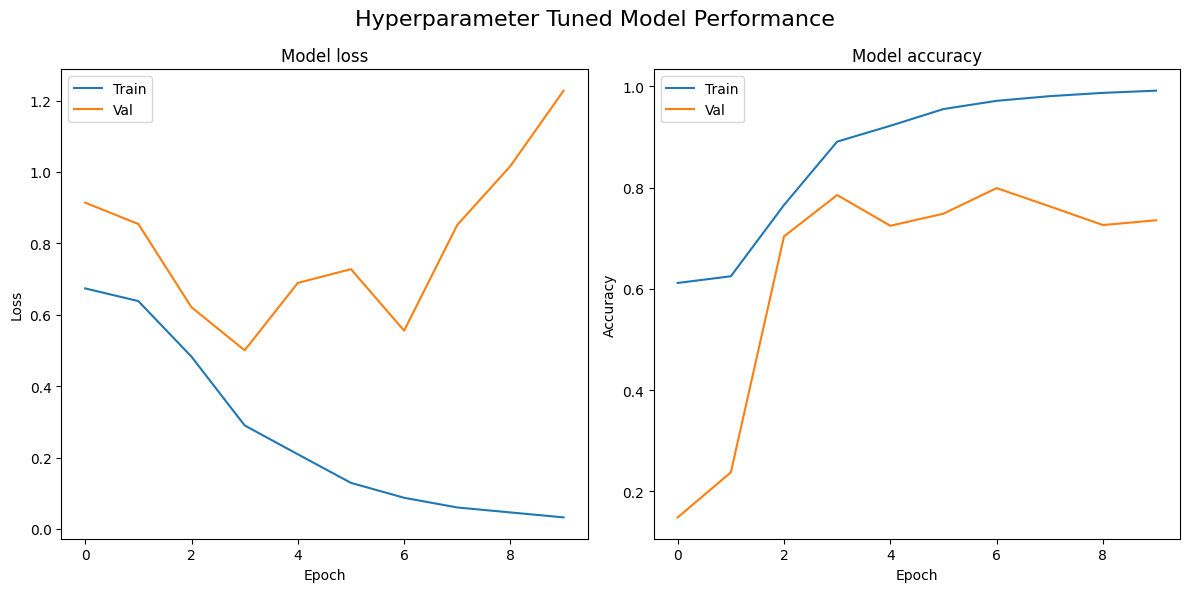

In [103]:
plot_history(history_tuned_model, title='Hyperparameter Tuned Model Performance')

**What were the best hyperparameters found? Why might that be performing better than others? [2 Pts]**

The best hyperparameters found were:
- Number of embedding dimensions: 128 (from 32)
- Number of LSTM units: 128 (from 32)
- Number of dense units: 192 (from 0, technically)
- Learning rate: 0.0001 (from 0.001, a tenth of the original value)

The higher number of embedding dimensions, LSTM units and newly introduced dense units as hidden layers all allow the model to capture more information about the reviews and the relationships between words. In addition, the lower learning rate allows the model to learn more slowly and avoid overshooting the optimal solution. This combination of hyperparameters allows the model to learn more effectively and generalize better to unseen data.

In [100]:
# Save keras model to local ONNX file
save_model_onxx(
    model=tuned_model, 
    model_filename="models/tuned_model.onnx",
    deep_learning=True
)

# Generate predictions and submit to competition
X_test_preproc = preprocessor(X_test)
upload_preds_to_aimodelshare(
    model=tuned_model,
    model_filename="models/tuned_model.onnx",
    X_test=X_test_preproc, 
    columns=y_train.columns,
    competition=mycompetition,
    preprocessor_filename="preprocessor.zip"
)

/opt/homebrew/Caskroom/miniforge/base/envs/AdvML/lib/python3.10/runpy.py:126: RuntimeWarning: 'tf2onnx.convert' found in sys.modules after import of package 'tf2onnx', but prior to execution of 'tf2onnx.convert'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
2024-04-30 05:47:07,220 - WARNING - ***IMPORTANT*** Installed protobuf is not cpp accelerated. Conversion will be extremely slow. See https://github.com/onnx/tensorflow-onnx/issues/1557
2024-04-30 05:47:07,222 - WARNING - '--tag' not specified for saved_model. Using --tag serve
2024-04-30 05:47:09,442 - WARNING - At this time, the v2.11+ optimizer `tf.keras.optimizers.RestoredOptimizer` runs slowly on M1/M2 Macs, please use the legacy Keras optimizer instead, located at `tf.keras.optimizers.legacy.RestoredOptimizer`.
2024-04-30 05:47:09,512 - INFO - Signatures found in model: [serving_default].
2024-04-30 05:47:09,512 - WARNING - '--signature_def' not specified, using first signature: serving_default
2024-0

Model saved to tuned_model.onnx
57/57 [==============================] - 2s 12ms/step

Your model has been submitted as model version 543

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.ai/detail/model:2763


In [ ]:
# Get leaderboard
show_leaderboard(mycompetition)

In [ ]:
# Compare two or more models
data = mycompetition.compare_models([1, 2, 3], verbose=1)
mycompetition.stylize_compare(data)

## 3 more models [30 Pts]

Train three more prediction models to try to predict the SST sentiment
dataset well.

○ Use Conv1d layers in first model [ 2 Pts]

○ Use Transfer learning with Glove Embeddings for 2nd model [10 Pts]

○ Third model can be any Transfer learning model of your choice (Transformer architecture required, eg. BERT and related) [10 Pts]

### Model 1: Conv1D Model

In [20]:
embedding_dim = 128
l2_reg = 0.01

model_conv1d = Sequential([
    Embedding(MAX_WORDS, embedding_dim, input_length=MAX_LENGTH),
    Conv1D(embedding_dim, 3, activation='swish', kernel_regularizer=l2(l2_reg)),
    BatchNormalization(),
    Conv1D(128, 3, activation='swish', kernel_regularizer=l2(l2_reg)),
    BatchNormalization(),
    Conv1D(256, 3, activation='swish', kernel_regularizer=l2(l2_reg)),
    BatchNormalization(),
    Conv1D(512, 3, activation='swish', kernel_regularizer=l2(l2_reg)),
    BatchNormalization(),
    GlobalMaxPooling1D(),
    Dense(256, activation='swish', kernel_regularizer=l2(l2_reg)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(64, activation='swish', kernel_regularizer=l2(l2_reg)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

model_conv1d.compile(optimizer=Adam(lr=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
display(model_conv1d.summary())

# Set up callbacks
checkpoint_conv1d = ModelCheckpoint('models/model_conv1d.h5', monitor='val_loss', verbose=1, save_best_only=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, mode='auto', min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto')

# Train Conv1D model
history_model_conv1d = model_conv1d.fit(
    preprocessor(X_train), y_train,
    epochs=20,
    batch_size=64,
    validation_split=0.2,
    callbacks=[checkpoint_conv1d, lr_scheduler, early_stopping]
)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 100, 128)          1280000   
                                                                 
 conv1d_16 (Conv1D)          (None, 98, 128)           49280     
                                                                 
 batch_normalization_24 (Ba  (None, 98, 128)           512       
 tchNormalization)                                               
                                                                 
 conv1d_17 (Conv1D)          (None, 96, 128)           49280     
                                                                 
 batch_normalization_25 (Ba  (None, 96, 128)           512       
 tchNormalization)                                               
                                                                 
 conv1d_18 (Conv1D)          (None, 94, 256)          

None

Epoch 1/20
87/87 [==============================] - ETA: 0s - loss: 12.4120 - accuracy: 0.5181
Epoch 1: val_loss improved from inf to 12.34938, saving model to models/model_conv1d.h5
87/87 [==============================] - 20s 166ms/step - loss: 12.4120 - accuracy: 0.5181 - val_loss: 12.3494 - val_accuracy: 0.1488 - lr: 0.0010
Epoch 2/20
87/87 [==============================] - ETA: 0s - loss: 9.9069 - accuracy: 0.5928
Epoch 2: val_loss improved from 12.34938 to 8.95729, saving model to models/model_conv1d.h5
87/87 [==============================] - 12s 132ms/step - loss: 9.9069 - accuracy: 0.5928 - val_loss: 8.9573 - val_accuracy: 0.1488 - lr: 0.0010
Epoch 3/20
87/87 [==============================] - ETA: 0s - loss: 7.3831 - accuracy: 0.7590
Epoch 3: val_loss improved from 8.95729 to 6.74643, saving model to models/model_conv1d.h5
87/87 [==============================] - 13s 153ms/step - loss: 7.3831 - accuracy: 0.7590 - val_loss: 6.7464 - val_accuracy: 0.1488 - lr: 0.0010
Epoch 4/2

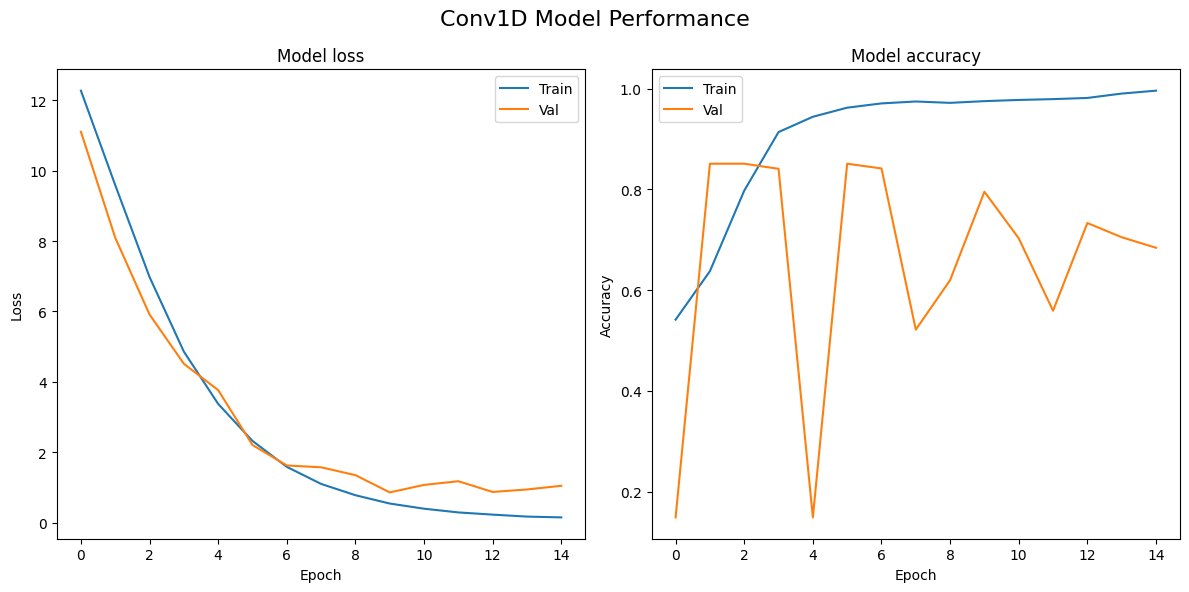

In [12]:
plot_history(history_model_conv1d, title='Conv1D Model Performance')

In [ ]:
# Save Conv1D model to ONNX file
save_model_onxx(
    model=model_conv1d, 
    model_filename="models/model_conv1d.onnx",
    deep_learning=True
)

# Generate predictions and submit to competition
upload_preds_to_aimodelshare(
    model=model_conv1d,
    model_filename="models/model_conv1d.onnx",
    X_test=preprocessor(X_test), 
    columns=y_train.columns,
    competition=mycompetition,
    preprocessor_filename="preprocessor.zip"
)

### Model 2: Transfer Learning with GloVe Embeddings
GloVe: Global Vectors for Word Representation

Code adapted from [Keras documentation](https://keras.io/examples/nlp/pretrained_word_embeddings/)

In [8]:
# First, download the GloVe embeddings
import os
if os.path.exists('data/glove/glove.6B.zip'):
    print("GloVe embeddings already downloaded.")
else: 
    !wget -P data/glove/ https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
    !unzip -q data/glove/glove.6B.zip

# Load the GloVe embeddings
# Make a dictionary mapping words (strings) to their NumPy vector representation
path_to_glove_file = "data/glove/glove.6B.200d.txt"
embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs
print("Found %s word vectors." % len(embeddings_index))

# Prepare the GloVe word-embedding matrix
# Create a matrix of shape (MAX_WORDS, EMBEDDING_DIM) to store the word vectors
embedding_dim = 128
embedding_matrix = np.zeros((MAX_WORDS, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i < MAX_WORDS:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            # This includes the representation for "padding" and "OOV" (out of vocabulary)
            embedding_matrix[i] = embedding_vector
print('Loaded %s word vectors.' % len(embeddings_index))
print('Shape of embedding matrix:', embedding_matrix.shape)
 
# Build the model
model_glove = Sequential([
    Embedding(MAX_WORDS, embedding_dim, input_length=MAX_LENGTH, weights=[embedding_matrix], trainable=False),
    LSTM(128, return_sequences=True),
    LSTM(64),
    Dense(64, activation='swish'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])
display(model_glove.summary())

# Compile the model
model_glove.compile(optimizer=Adam(lr=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Set up callbacks
checkpoint_glove = ModelCheckpoint('models/model_glove.h5', monitor='val_loss', verbose=1, save_best_only=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, mode='auto', min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')

# Train the model
history_model_glove = model_glove.fit(
    preprocessor(X_train), y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    callbacks=[checkpoint_glove, lr_scheduler, early_stopping]
)

GloVe embeddings already downloaded.
Found 400000 word vectors.
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 100)          1000000   
                                                                 
 lstm_2 (LSTM)               (None, 100, 128)          117248    
                                                                 
 lstm_3 (LSTM)               (None, 64)                49408     
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 2)                 130       
                                                        

None

Epoch 1/20
173/173 [==============================] - ETA: 0s - loss: 0.5944 - accuracy: 0.6741
Epoch 1: val_loss improved from inf to 0.51580, saving model to models/model_glove.h5
173/173 [==============================] - 9s 36ms/step - loss: 0.5944 - accuracy: 0.6741 - val_loss: 0.5158 - val_accuracy: 0.8056 - lr: 0.0010
Epoch 2/20
172/173 [============================>.] - ETA: 0s - loss: 0.4991 - accuracy: 0.7587
Epoch 2: val_loss did not improve from 0.51580
173/173 [==============================] - 5s 30ms/step - loss: 0.4987 - accuracy: 0.7594 - val_loss: 0.5744 - val_accuracy: 0.7406 - lr: 0.0010
Epoch 3/20
173/173 [==============================] - ETA: 0s - loss: 0.4506 - accuracy: 0.7887
Epoch 3: val_loss did not improve from 0.51580
173/173 [==============================] - 5s 29ms/step - loss: 0.4506 - accuracy: 0.7887 - val_loss: 0.5893 - val_accuracy: 0.7182 - lr: 0.0010
Epoch 4/20
172/173 [============================>.] - ETA: 0s - loss: 0.4200 - accuracy: 0.7987
E

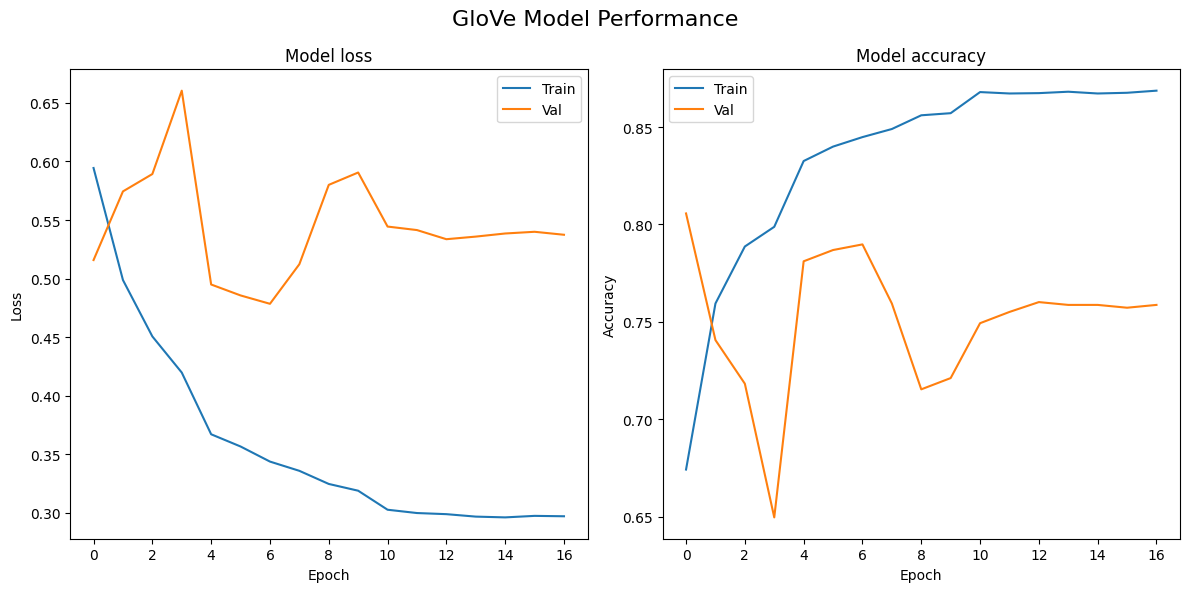

In [9]:
plot_history(history_model_glove, title='GloVe Model Performance')

In [11]:
# Save GloVe model to ONNX file
save_model_onxx(
    model=model_glove, 
    model_filename="models/model_glove.onnx",
    transfer_learning=True,
    deep_learning=True,
)

# Generate predictions and submit to competition
upload_preds_to_aimodelshare(
    model=model_glove,
    model_filename="models/model_glove.onnx",
    X_test=preprocessor(X_test), 
    columns=y_train.columns,
    competition=mycompetition,
    preprocessor_filename="preprocessor.zip"
)

/opt/homebrew/Caskroom/miniforge/base/envs/AdvML/lib/python3.10/runpy.py:126: RuntimeWarning: 'tf2onnx.convert' found in sys.modules after import of package 'tf2onnx', but prior to execution of 'tf2onnx.convert'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
2024-04-30 06:45:59,158 - WARNING - ***IMPORTANT*** Installed protobuf is not cpp accelerated. Conversion will be extremely slow. See https://github.com/onnx/tensorflow-onnx/issues/1557
2024-04-30 06:45:59,160 - WARNING - '--tag' not specified for saved_model. Using --tag serve
2024-04-30 06:46:03,144 - WARNING - At this time, the v2.11+ optimizer `tf.keras.optimizers.RestoredOptimizer` runs slowly on M1/M2 Macs, please use the legacy Keras optimizer instead, located at `tf.keras.optimizers.legacy.RestoredOptimizer`.
2024-04-30 06:46:03,210 - INFO - Signatures found in model: [serving_default].
2024-04-30 06:46:03,211 - WARNING - '--signature_def' not specified, using first signature: serving_default
2024-0

Model saved to models/model_glove.onnx
57/57 [==============================] - 1s 11ms/step

Your model has been submitted as model version 545

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.ai/detail/model:2763


### Model 3: Transfer Learning with BERT

In [ ]:
from transformers import BertTokenizer, TFBertModel

# Load the BERT model and tokenizer
bert_model = TFBertModel.from_pretrained('bert-base-uncased')
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Generate BERT embeddings
input_ids = Input(shape=(MAX_LENGTH,), dtype=tf.int32, name='input_ids')
attention_mask = Input(shape=(MAX_LENGTH,), dtype=tf.int32, name='attention_mask')
outputs = bert_model(input_ids, attention_mask=attention_mask)

# With the output of the BERT model, we can add additional layers to build a classification model
pooled_output = outputs.pooler_output
x = tf.keras.layers.Dropout(0.1)(pooled_output)
x = tf.keras.layers.Dense(32, activation='swish')(x)
output = tf.keras.layers.Dense(2, activation='softmax')(x)

# Build the final model
model_bert = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=output)

model_bert.compile(optimizer=Adam(lr=2e-5), loss='categorical_crossentropy', metrics=['accuracy'])

display(model_bert.summary())

# Set up callbacks
checkpoint_bert = ModelCheckpoint('models/model_bert.h5', monitor='val_loss', verbose=1, save_best_only=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, mode='auto', min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')

# Tokenize text data
X_train_bert = bert_tokenizer(X_train.tolist(), padding='max_length', max_length=MAX_LENGTH, return_tensors='tf')

# Train the model
history_model_bert = model_bert.fit(
    {'input_ids': X_train_bert['input_ids'],
     'attention_mask': X_train_bert['attention_mask']},
    y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    callbacks=[checkpoint_bert, lr_scheduler, early_stopping]
)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 100)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 100)]                0         []                            
 )                                                                                                
                                                                                                  
 tf_bert_model_5 (TFBertMod  TFBaseModelOutputWithPooli   1094822   ['input_ids[0][0]',           
 el)                         ngAndCrossAttentions(last_   40         'attention_mask[0][0]']      
                             hidden_state=(None, 100, 7                                     

None

Epoch 1/20


: 

In [ ]:
plot_history(history_model_bert, title='BERT Model Performance')

In [ ]:
# Save BERT model to ONNX file
save_model_onxx(
    model=model_bert, 
    model_filename="models/model_bert.onnx",
    transfer_learning=True,
    deep_learning=True
)

# Generate predictions and submit to competition
X_test_bert = bert_tokenizer(X_test.tolist(), padding='max_length', max_length=MAX_LENGTH, return_tensors='tf')
upload_preds_to_aimodelshare(
    model=model_bert,
    model_filename="models/model_bert.onnx",
    X_test={'input_ids': X_test_bert['input_ids'], 'attention_mask': X_test_bert['attention_mask']},
    columns=y_train.columns,
    competition=mycompetition,
    preprocessor_filename="preprocessor.zip"
)

### Extra credits : Train any models of your choice [+10 Extra Points]

In [ ]:
# Any modern models of your choice (should be released after BERT)

Tabularize results from ALL your models in this notebook and compare performance [5 Pts]

Results Discussion : Point out why specific models may have performed better than others. and discuss failures if any. [3 Pts]

# Python Inference pipeline on unseen dataset [45 Points (35 Pts + 10 Extra Credits)]

## <b>Github Repo: </b>

## **Part 1. [25 Pts]**

You will exercise **Modularization** and Good Github organization: You should take the relevant code and make it into classes across different python (.py) files so that you can just import those files and/or classes and/or functions and/or modules, instantiate the model using them, load weights from your saved models, and start predicting on any new set of test reviews (an unseen larger test dataset).

Essentially, you should have a simple and clean **"front-end" notebook** where you download your trained and saved models from say a personal drive link, and have an inference pipeline ready within about **10 lines of code** to predict on any new unseen Movie reviews dataset after loading it from a csv.

This time you will provide a choice of 3 trained models to choose from (atleast 2 from the last 3 models section + extra credit section if you did it) . You will give us a list of strings as a comment, and should provide the functionality to just specify the model to load using one of the 3 strings. An outline is detailed below.

<br><br>
**We have provided a test_sample.csv with 100 rows for you to test your front-end notebook.**

Your notebook should import relevant classes and modules on the back-end, and should load weights and subsequently just take the "review" column of given test_sample.csv and predict 'positive' or 'negative' sentiment on it (see outline of code below). Use the "sentiment" column from the test_sample csv ONLY when finally comparing your own predictions with it and output a classification report.

You should use a local environment with all packages installed and an IDE like VScode or PyCharm etc. to be able to do this section efficiently. There is no aimodelshare invlved in this section, and there shouldn't be any mention of it.



<br><br>
### Environment Requirements
Include a pip requirements.txt file for your environment.
Use the following command to generate it automatically:

```$ pip freeze > requirements.txt```

When evaluating this section, we will run

```pip install -r requirements.txt```

to recreate the exact environment you have locally and then test your code.

**ENSURE** that this works as intended by creating another new virtual conda environment, cloning your own latest Github commit locally from scratch, installing packages using your requirements.txt file, and following all the instructions you provide in the Readme and the front-end notebook to run the inference pipeline on the sample data. We will do the exact same steps to replicate it, and then substitute test sample with the actual dataset to evaluate this section.




## Outline for front-end notebook:

In [ ]:
## You will include code to load the test_sample.csv in your Front-end notebok
## Note that this csv can be of any large length, and you will predict on it using one of 3 models you provide weights for.

In [ ]:
# Provide a comment like this:



### Hi User! Please choose a model between ["Glove150d", "DistillBERT", "GPT2"]

model_name = "DistillBERT"  # Choice to modify model name from your given list


## Now call appropriate class/function from backend to download relevant weights, instantiate specified model and load the weights, and return the loaded model, ready to predict

## load the test csv:
import pandas as pd

test_data = pd.read_csv("test_sample.csv")
test_reviews=test_data.review


# Make sure your notebook can run your inference pipeline on the loaded test_sample.csv reviews.  

# **You will recieve a ZERO (0) for this section if any of the following cases are true:**
### - If there is no front-end notebook, or no python (.py) files where you have declared classes, modules and functions to delegate all the work in backend
### - If there is no requirements.txt file in your repo
### - If after installing requirements in a new environment, following the  instructions in your Readme or Notebook does not lead to any valid output upon running the front-end notebook.
### - If your notebook does not output the final classification report and matrix for at least 1 model after predicting on test_sample
### - If you include or run any Training code in your front-end notebook or python files in github repository
### - If you include more than 30 lines of code in the front-end notebook (apart from importing your functions, classes from your modules)
### - If you attempt to use the 'sentiment' column from the test_sample for any  purpose other than comparison of your final predictions with it, and transforming it if needed.



<br><br>
# **You will recieve 25 + 10 EXTRA points if you do this section well.**

### How to do this section well:

Get a proper understanding of object-oriented programming in python. Learn what classes and modules are if you don't know already. Try to **encapsulate all code** within appropriately named classes and its functions. Each class and function should have a specific isloated purpose. All the classes and functions you design would talk to each other efficiently and handle everything in the background without needing to get back to the front-end notebook for outputting or retreiving intermediate objects.

In the front-end notebook, you essentially only need to include code to send the model name to backend using 1 function, get the loaded model back, read and send the test reviews to backend for predicting with this loaded model, then load the ground truth and straight up output the classification report from the backend (less than 10 lines of code)

The majority of your code should never be exposed directly in python files without being inside a class or a function. Only explicitly needed global variables, imports or declarations should be done outside the scope of a function or a class.

<br><br>
### Documentation

Include **Docstrings** for each function and class, define the input parameters and outputs, what they are and what data type they are expected to be in.

Example of a good docstring:
```python
def calculate_rectangle_area(length: float, width: float) -> float:
    """
    Calculate the area of a rectangle.

    This function takes the length and width of a rectangle and returns its area. The calculation assumes that the input values are in the same unit and will return the area in that unit squared.

    Parameters:
    - length (float): The length of the rectangle. Must be a positive number.
    - width (float): The width of the rectangle. Must be a positive number.

    Returns:
    - area (float): The calculated area of the rectangle in the unit squared of the input measurements.

    Raises:
    - ValueError: If either the length or width is non-positive.

    """


    if length <= 0 or width <= 0:
        raise ValueError("Length and width must be positive numbers.")

    area = length * width

    return area
```



<br><br>
### **Part 2. [5 Pts]**

In the **README.md** file of your repository should be an overall outline of your experiments, including the models you trained succesfully and have results for - summarized in a tabular way. You can include other details in your readme as well, but not too detailed. Consider this an exposition of your project for someone who does not know anything about this project.


Include instructions on how to install requirements, how to run your front-end notebook and describe which 3 models you gave choice to load and predict on.


Include a tree structure of your files in the github repository.

Example:
```
$ tree
.
├── dir1
│   ├── file11.ext
│   └── file12.ext
├── dir2
│   ├── file21.ext
│   ├── file22.ext
│   └── file23.ext
├── dir3
├── file_in_root.ext
└── README.md

3 directories, 7 files
```

Look at different readme's across github to see how they are organized. Refer to [this resource](https://docs.github.com/en/get-started/writing-on-github/getting-started-with-writing-and-formatting-on-github/basic-writing-and-formatting-syntax) to learn how to format the file.

- Example of a [Good Readme File](https://github.com/hankcs/HanLP) (We have no affiliations with Author)
- Example of a [Bad Readme File](https://github.com/tstran155/AG-News-Topic-Classification-and-Topic-Modeling-using-Natural-Language-Processing)
- Example of an [Acceptable/OK Readme File](https://github.com/lonePatient/Bert-Multi-Label-Text-Classification)
: This is the minimum level at which you should have your Readme

Note that these examples are different from the last assignment.

<br><br>
### **Part 3. [5 Pts]**

In the **Final report** (.ipynb) notebook, put whatever code, visuals and results you think are relevant. It is open ended, you should not just post a copy of this notebook for it. It should be brief, clean and succinct as has been instructed before. No residues from the assignment should be present, it should look like a professional report of experiments conducted.





#### Do not forget to link the final Github repository containing the Front-end running notebook, your code, Readme and Final report at the top of this notebook.